## Notebook 3: Mountain Ranges

In this notebook we will try to combine mountains into mountain ranges (and individual river basins into watersheds).

In prior notebooks we determined what the mountains are by looking at the highest paths in elevation.
However, that gives us loads of peaks, and its unfortunately hard to get meaning from that.

Rather, we can group mountains that seem to be part of the same generally mass, a mountain range.

In [1]:
## Import Statements
import numpy as np
import matplotlib.pyplot as plt
from src.map_image import *
from src.map_instance import *
from src.map_data import *
from src.map_transforms import *

%config InlineBackend.figure_format = 'retina'

# Parameters
params = {
    'dataset':'TBI',
    'region': 'hawaii',
    'minutes_per_node': 1,
    'image_folder': 'img/03/',
    'n_neighbors': 4,
}

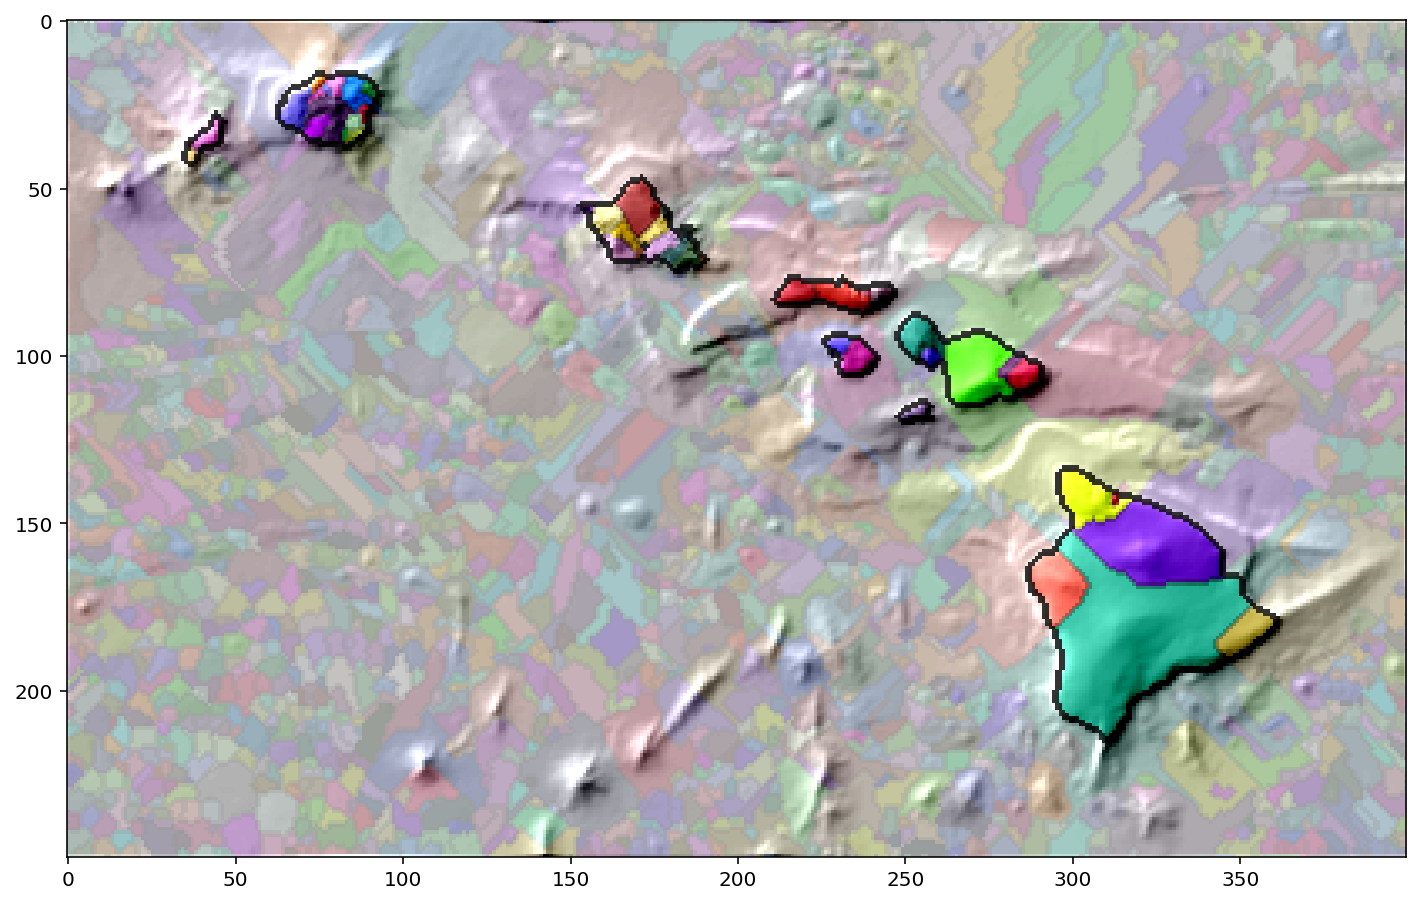

In [2]:
# Regenerate Elevation information and prepare many supporting maps

maps = {} # These should all be map instances
maps['elevation'] = loadRegionMap(
    region=params['region'], 
    dataset=params['dataset'], 
    minutes_per_node=params['minutes_per_node'], 
    image_folder=params['image_folder'],
)
maps['hillshade'] = getHillshade(maps['elevation'], 1)
maps['sea'] = maps['elevation'].newChildInstance(
    {'values': 'sea'},
    maps['elevation'].getDataFlat() < 0,
)
maps['coast'] = getBorder(maps['sea'], 1)
params['n_nodes'] = maps['elevation'].getNumNodes()

# Mountains
maps['highest_neighbor_index'] = getHighestNeighbor(maps['elevation'])
maps['mountain'] = getLocalPeaks(maps['highest_neighbor_index'])
maps['mountain_border'] = getBorder(maps['mountain'], 1)
RasterImage(maps['elevation']) \
    .addLayer('base', 1) \
    .addLayer('mountain_border', 0.7, nodes_selected=maps['mountain_border'].getDataFlat()) \
    .addLayer('mountain', maps['mountain'].getDataFlat(), colormap='hashed', transforms=['norm'], combine='multiply', opacity=0.5) \
    .addLayer('sea', 1.2, nodes_selected=maps['sea'].getDataFlat(), combine='add', dissolve=.2) \
    .addLayer('hillshade', maps['hillshade'].getDataFlat(), combine='add', opacity=1, dissolve=1) \
    .addLayer('coast', .2, nodes_selected=maps['coast'].getDataFlat(), combine='multiply') \
    .display().overrideLayerNames(['mountains']).final()

In [3]:
# Compute Neighbors / Adjacency List (useful for some algorithms)
#
# While some algorithms work well on linear arithmetic -- some are too hard to handle en masse
# Rather, we can compute the adjacency list and utilize that in algorithms
nodes_neighbors = getNodesNeighbors(
    maps['elevation'].getNumRows(),
    maps['elevation'].getNumCols(),
    params['n_neighbors'],
    wrap=False
)

## Algorithm 1

In order to determine mountain ranges, we will iterate through the mountains themselves.
Starting at the lowest mountains -- find the border node to the highest other mountain and associate that.
This will build chains of mountains / mountain ranges (mntrange).

From early investigation though, it does not appear quite right.
In the Hawaii map, if we stop the merging right before the last few peaks (20 left to go) we can see wide swatches of the ocean floor pointing to unexpected places.
There's a ridge west of Hawaii that is part of the Kauai range and part that is in the Molokai range -- why the split?
I think going from the lowest mountain peak to the highest is causing this problem, making changes of low peaks by coincedence, not intention.

### Asymptotic Analysis

n = # of nodes
m = # of mountains (probably n^0.5 or logn, but depends on the data)
r = # of nodes in mountain range (starts n/m but eventually tends to n)
e = # of neighbors (basically constant since it's 4 or 8, does not scale w/ map size

While there certainly are optimizations done by numpy, let's first estimate the efficiency assuming all array lookups and all transforms on arrays cost the size of the array.

* sort peaks O(m * logm)
* for each mountain, O(m)
  * find nodes in mountain range O(n)
  * for each node in mountain range O(r)
     * for neighbors of this node O(e) -- basically O(1)
        * lookup values, mnt ranges... O(1)
  * assign nodes in this mountain range to the taller one O(r)
  
Thereby, it looks like O(m*logm + m*r*e), which worst case maxes out at O(n^2), surprisingly not bad.
We could potentially speed it up by decreasing work in the loop for the mountain range -- if we keep track of what nodes are border nodes versus inner nodes (and thereby don't need to be checked) -- but it would only save the neighbor checks.

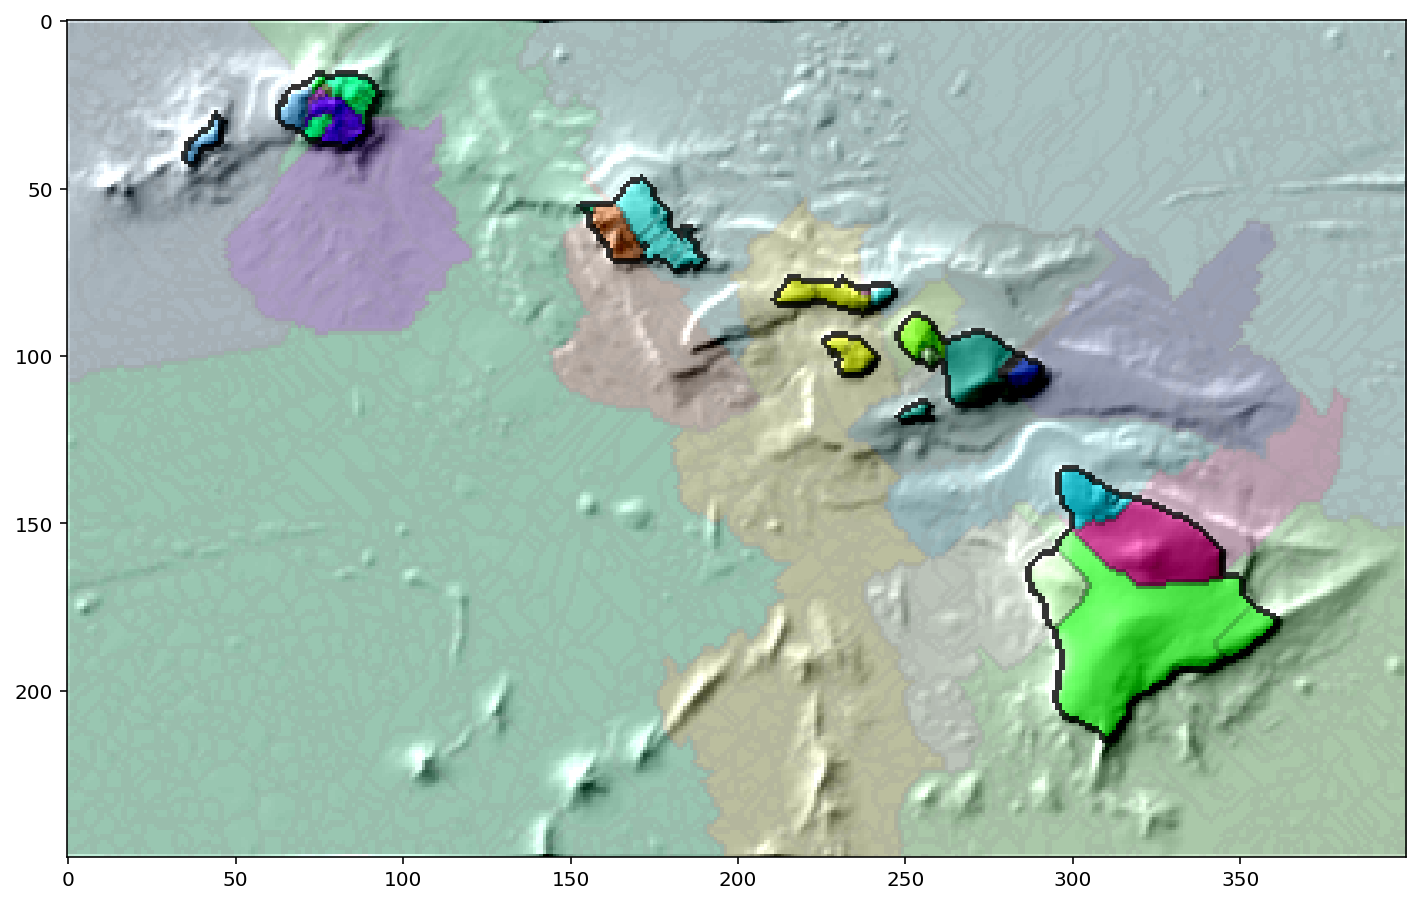

In [4]:
# in order to combine mountains into mountain ranges
# let's find the border of the mountain
# find the highest point outside of that border, and consider that the output of the mountain

def computeMountainRangesAlgo1(params, maps, draw=True):
    peaks_index = np.unique(maps['mountain'].getDataFlat())
    peaks_mntrange = np.full(params['n_nodes'], -1)
    peaks_ridge_node_in = np.full(params['n_nodes'], -1)
    peaks_ridge_node_out = np.full(params['n_nodes'], -1)

    nodes_mntrange = maps['mountain'].getDataFlat()

    nodes_value = maps['elevation'].getDataFlat()
    peaks_value = nodes_value[peaks_index]
    i_sorted_peaks = np.argsort(peaks_value)

    for i_peak in i_sorted_peaks[:-20]:
        peak_index = peaks_index[i_peak]
        mntrange_nodes = np.array(np.where(nodes_mntrange == peak_index)).flatten()

        # Search for the highest node outside of the mountain and consider that edge the "ridge"
        mountain_index = peak_index
        ridge_node_in = -1
        ridge_node_in_value = -1e6
        ridge_node_out = -1
        ridge_node_out_value = -1e6

        for mountain_node_index in mntrange_nodes:
            mountain_node_value = nodes_value[mountain_node_index]
            for neighbor_index in nodes_neighbors[mountain_node_index,:]:
                # Exclude not wrapping neighbors and neighbors that are already in the same mountain
                if (neighbor_index == -1 or nodes_mntrange[neighbor_index] == mountain_index):
                    continue

                # If the neighboring node is the highest neighbor found so far and the mountain node value is the highest
                # Consider it the best possible ridge candidate
                neighbor_value = nodes_value[mountain_node_value]
                if (neighbor_value > ridge_node_out_value and mountain_node_value > ridge_node_in_value):
                    ridge_node_in = mountain_node_index
                    ridge_node_in_value = mountain_node_value
                    ridge_node_out = neighbor_index
                    ridge_node_out_value = neighbor_value

        # Mark this as the ridge out and mark this other peak as the parent peak
        mntrange = nodes_mntrange[ridge_node_out]
        peaks_mntrange[i_peak] = mntrange
        peaks_ridge_node_in[i_peak] = ridge_node_in
        peaks_ridge_node_out[i_peak] = ridge_node_out

        # if(nodes_value[mntrange] > nodes_value[mountain_index]):
        # if(ridge_node_out_value < 0):
        nodes_mntrange[mntrange_nodes] = mntrange


    # Draw the map
    if draw:
        map_mntrange = maps['mountain'].newChildInstance({'values': 'mntrange'}, nodes_mntrange)
        map_mntrange_border = getBorder(map_mntrange, 1)

        RasterImage(maps['elevation']) \
            .addLayer('base', 1) \
            .addLayer('mountain_border', 0.8, nodes_selected=maps['mountain_border'].getDataFlat()) \
            .addLayer('mntrange_border', 0.8, nodes_selected=map_mntrange_border.getDataFlat(), combine='multiply') \
            .addLayer('mntrange', map_mntrange.getDataFlat(), colormap='hashed', combine='multiply', opacity=0.5) \
            .addLayer('sea', 1.2, nodes_selected=maps['sea'].getDataFlat(), combine='add', dissolve=.2) \
            .addLayer('hillshade', maps['hillshade'].getDataFlat(), combine='add', opacity=1, dissolve=1) \
            .addLayer('coast', 0.2, nodes_selected=maps['coast'].getDataFlat(), combine='multiply') \
            .display().overrideLayerNames(['mountain_range_algo1_holdout20peakmerges']).save().final()
    
computeMountainRangesAlgo1(params, maps)


## Algorithm 2

This tries a different algorithm instead -- instead we iterate over every node.
I'm not a fan of going over every node (doing it per mountain is better) -- but we had to go over every node in the prior algorithm anyway so perhaps this is more efficient.

The idea is that we are reconstructing the mountains from the high values to the lower ones -- which should keep ridges w/ small gaps together better than before.


### Asymptotic Analysis

n = # of nodes
m = # of mountains (probably n^0.5 or logn, but depends on the data)
r = # of nodes in mountain range (starts n/m but eventually tends to n)

* sort all nodes O(n * logn)
* for all nodes O(n)
   * for all neighbors O(e)
      * lookups, comparisons, and assignment
      * merge two regions O(n)

Thereby, this algorithm has at most a O(n * n * e) runtime -- but since we only expect to have m merges and e is effectively constant, it's closer to O(n * m)


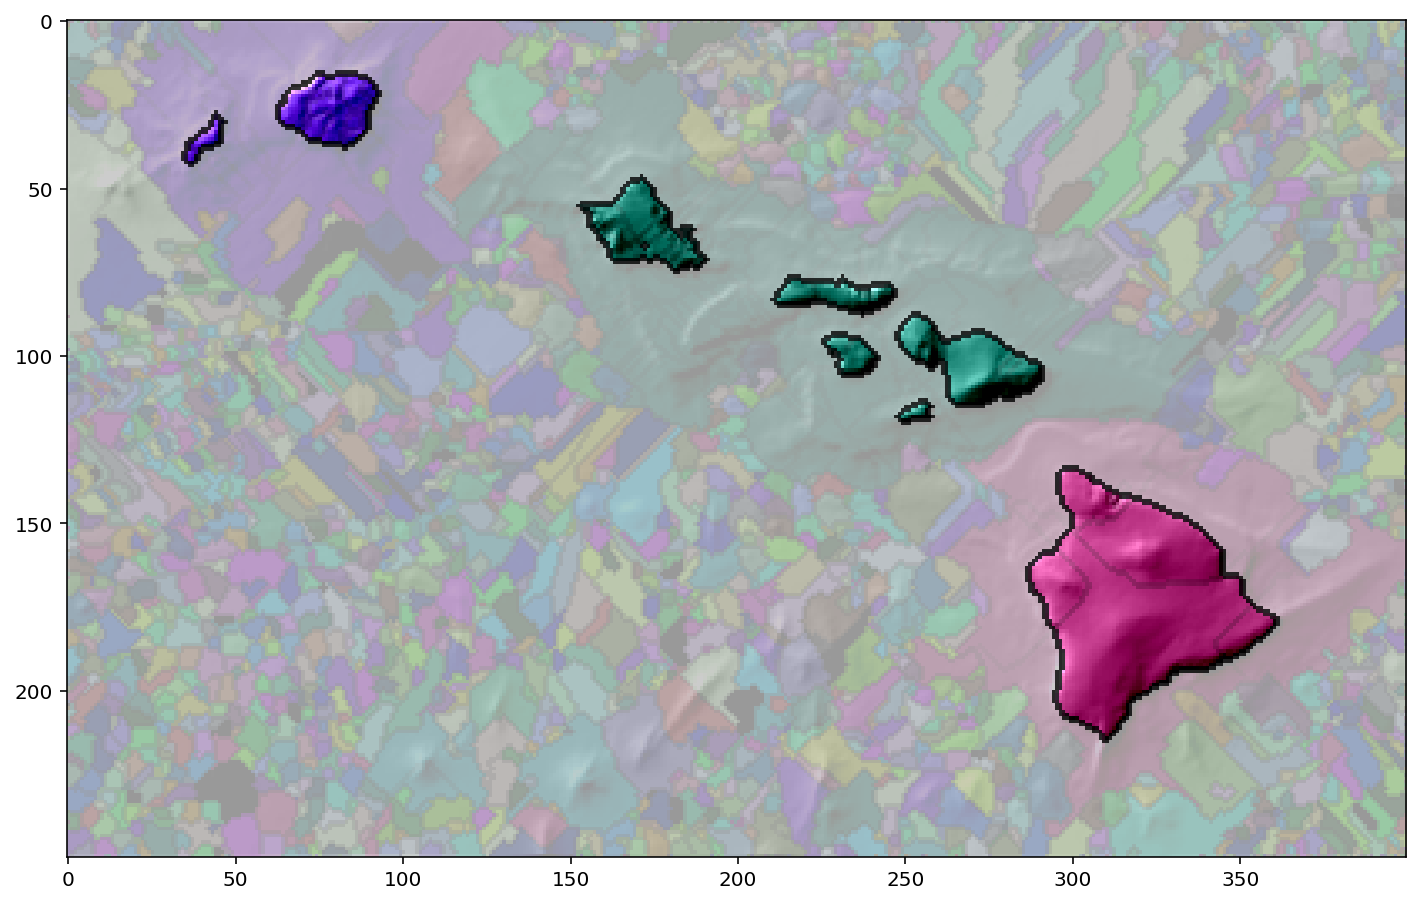

In [5]:
# Hmmm, that combined map does not look right
# Instead of going by peaks, we should go by nodes

def getMountainRangeMergePoints(params, maps):
    nodes_mountain = maps['mountain'].getDataFlat()
    nodes_mntrange = nodes_mountain.copy()
    
    # output data
    merges = []
    nodes_mntrange_snapshot = np.zeros(params['n_nodes'], dtype=int)
    nodes_peak_mntrange_parent = np.zeros(params['n_nodes'], dtype=int) - 1 # not necessarily used
    
    def mergeTwoRanges(lo_index, hi_index):
        lo_mountain = nodes_mountain[lo_index]
        hi_mountain = nodes_mountain[hi_index]
        lo_mntrange = nodes_mntrange[lo_index]
        hi_mntrange = nodes_mntrange[hi_index]
        nodes_mntrange[nodes_mntrange == lo_mntrange] = hi_mntrange
        nodes_peak_mntrange_parent[lo_mntrange] = hi_mntrange
        
        return {
            'bridge_lo_index': lo_index,
            'bridge_lo_value': nodes_value[lo_index],
            'bridge_hi_index': hi_index,
            'bridge_hi_value': nodes_value[hi_index],
            'mountain_lo': lo_mountain,
            'mountain_hi': hi_mountain,
            'mntrange_lo': lo_mntrange,
            'mntrange_hi': hi_mntrange,
            'landsea_local_interface': # Values are the high-side mountain, the bridge, then the low-side mountain
                ('L' if nodes_value[hi_mountain] > 0 else 'S') + 
                ('L' if nodes_value[hi_index] > 0 else 'S') + 
                ('L' if nodes_value[lo_mountain] > 0 else 'S'),
            'landsea_range_interface': # Values are the high mountain range, the bridge, then the low mountain range
                ('L' if nodes_value[hi_mntrange] > 0 else 'S') + 
                ('L' if nodes_value[hi_index] > 0 else 'S') + 
                ('L' if nodes_value[lo_mntrange] > 0 else 'S'),
            'distance_between_bridge_and_hi_local_peak':
                max(nodes_value[hi_mountain], nodes_value[lo_mountain]) - nodes_value[hi_index],
            'distance_between_bridge_and_hi_range_peak': nodes_value[hi_mntrange] - nodes_value[hi_index],
        }
        
    nodes_value = maps['elevation'].getDataFlat()
    nodes_index_hi_to_lo = np.argsort(-nodes_value);
    for i_explorer in np.arange(params['n_nodes']):
        explorer_index = nodes_index_hi_to_lo[i_explorer]
        node_value = nodes_value[explorer_index]
        explorer_mntrange = nodes_mntrange[explorer_index]

        if i_explorer == (params['n_nodes'] // 8):
            nodes_mntrange_snapshot = nodes_mntrange.copy()

        for neighbor_index in nodes_neighbors[explorer_index,:]:
            # Exclude not wrapping neighbors and neighbors that are already in the same mountain range
            if (neighbor_index == -1 or nodes_mntrange[neighbor_index] == explorer_mntrange):
                continue

            # They are different!
            neighbor_mntrange = nodes_mntrange[neighbor_index]

            if (nodes_value[explorer_mntrange] > nodes_value[neighbor_mntrange]):
                # The node's mountain range is taller, merge into that
                mergePoint = mergeTwoRanges(neighbor_index, explorer_index)
            else:
                # The neighbor's mountain peak is taller, merge into that
                mergePoint = mergeTwoRanges(explorer_index, neighbor_index)
                
                # Update the explorers mountain range
                explorer_mntrange = neighbor_mntrange
            merges.append(mergePoint)
            
    return [merges, nodes_mntrange_snapshot]

[merges, nodes_mntrange_snapshot] = getMountainRangeMergePoints(params, maps)
            
# Draw the map
map_mntrange = maps['mountain'].newChildInstance({'values': 'parent_peak'}, nodes_mntrange_snapshot)
map_mntrange_border = getBorder(map_mntrange, 1)
RasterImage(maps['elevation']) \
    .addLayer('base', 1) \
    .addLayer('mountain_border', 0.8, nodes_selected=maps['mountain_border'].getDataFlat()) \
    .addLayer('mntrange_border', 0.8, nodes_selected=map_mntrange_border.getDataFlat(), combine='multiply') \
    .addLayer('mntrange', map_mntrange.getDataFlat(), colormap='hashed', combine='multiply', opacity=0.5) \
    .addLayer('hillshade', maps['hillshade'].getDataFlat(), combine='add', opacity=1, dissolve=1) \
    .addLayer('sea', 1.2, nodes_selected=maps['elevation'].getDataFlat() < 0, combine='add', dissolve=.2) \
    .addLayer('coast', 0.2, nodes_selected=maps['coast'].getDataFlat(), combine='multiply') \
    .display().overrideLayerNames(['mountain_range_algo2_eighththrough']).final()
    

In [6]:
# Some descriptive statistics
def printEarlyMountainRangeStats(merges, nodes_mountain): 
    print('How many things do we have?')
    print('{:10d} nodes (pixel), points across the map along a 2-dimensional grid'.format(len(nodes_mountain)))
    print('{:10d} mountains, groupings where all of the nodes in a local area point upward to a single point'.format(len(np.unique(nodes_mountain))))
    print('{:14s} peaks or summits are the highest point in these mountains and are used to index them'.format(''))
    print('{:10d} merges, times where two mountains are combined, based on the highest point outward from a mountain'.format(len(merges)))
    print('{:14s} bridges or saddles are the name for the specific points where the merge happens'.format(''))
    print('{:14s} ridges are the paths connecting bridges to their peak -- following the highest locale nodes'.format(''))

    print('')
    print('Let\'s now think of how mountains intersect and are combined along the bridge nodes')
    print('Think of the intersections like V shapes. tall peak -> bridge -> small peak -- are these Vs tall? Are they partially underwater?')
    
    print('')
    print('Do the ridges in the connections cross the water line / interface? Considering what is above water (L) or below (S)?')
    landsea_local_interfaces = np.array([x['landsea_local_interface'] for x in merges])
    landsea_range_interfaces = np.array([x['landsea_range_interface'] for x in merges])
    print('{:18s}: {:6s} {:6s}'.format('Interface Pattern','Local','Range'))
    for interface_pattern in sorted(np.unique(landsea_local_interfaces)):
        print('{:18s}: {:6d} {:6d}'.format(
            interface_pattern,
            np.sum(landsea_local_interfaces == interface_pattern),
            np.sum(landsea_range_interfaces == interface_pattern),
        ))
        
    print('')
    print('What\'s the distance between the bridge & the tall peak?')
    print('    local = neighboring mountains, range = among the range its connected to.')
    log_base = 10 ** 0.5
    local_distances_logged_rounded = np.log(np.array([x['distance_between_bridge_and_hi_local_peak'] for x in merges])+0.001) // np.log(log_base)
    range_distances_logged_rounded = np.log(np.array([x['distance_between_bridge_and_hi_range_peak'] for x in merges])+0.001) // np.log(log_base)
    print('{:16s}: {:6s} {:6s}'.format('Distance','Local','Range'))
    for distance_group in sorted(np.unique(range_distances_logged_rounded)):
        group_min = int(np.exp(distance_group * np.log(log_base)))
        group_max = int(np.exp((distance_group + 1) * np.log(log_base)))
        print('{:6d} to {:6d}: {:6d} {:6d}'.format(
            group_min, group_max,
            np.sum(local_distances_logged_rounded == distance_group),
            np.sum(range_distances_logged_rounded == distance_group),
        ))
    
printEarlyMountainRangeStats(merges, maps['mountain'].getDataFlat())

How many things do we have?
    100000 nodes (pixel), points across the map along a 2-dimensional grid
      2337 mountains, groupings where all of the nodes in a local area point upward to a single point
               peaks or summits are the highest point in these mountains and are used to index them
      2336 merges, times where two mountains are combined, based on the highest point outward from a mountain
               bridges or saddles are the name for the specific points where the merge happens
               ridges are the paths connecting bridges to their peak -- following the highest locale nodes

Let's now think of how mountains intersect and are combined along the bridge nodes
Think of the intersections like V shapes. tall peak -> bridge -> small peak -- are these Vs tall? Are they partially underwater?

Do the ridges in the connections cross the water line / interface? Considering what is above water (L) or below (S)?
Interface Pattern : Local  Range 
LLL               

# Ridgelines and Rivers

In this next group of images and algorithms, lets visualize the ridgelines as these mountain ranges are combined together.

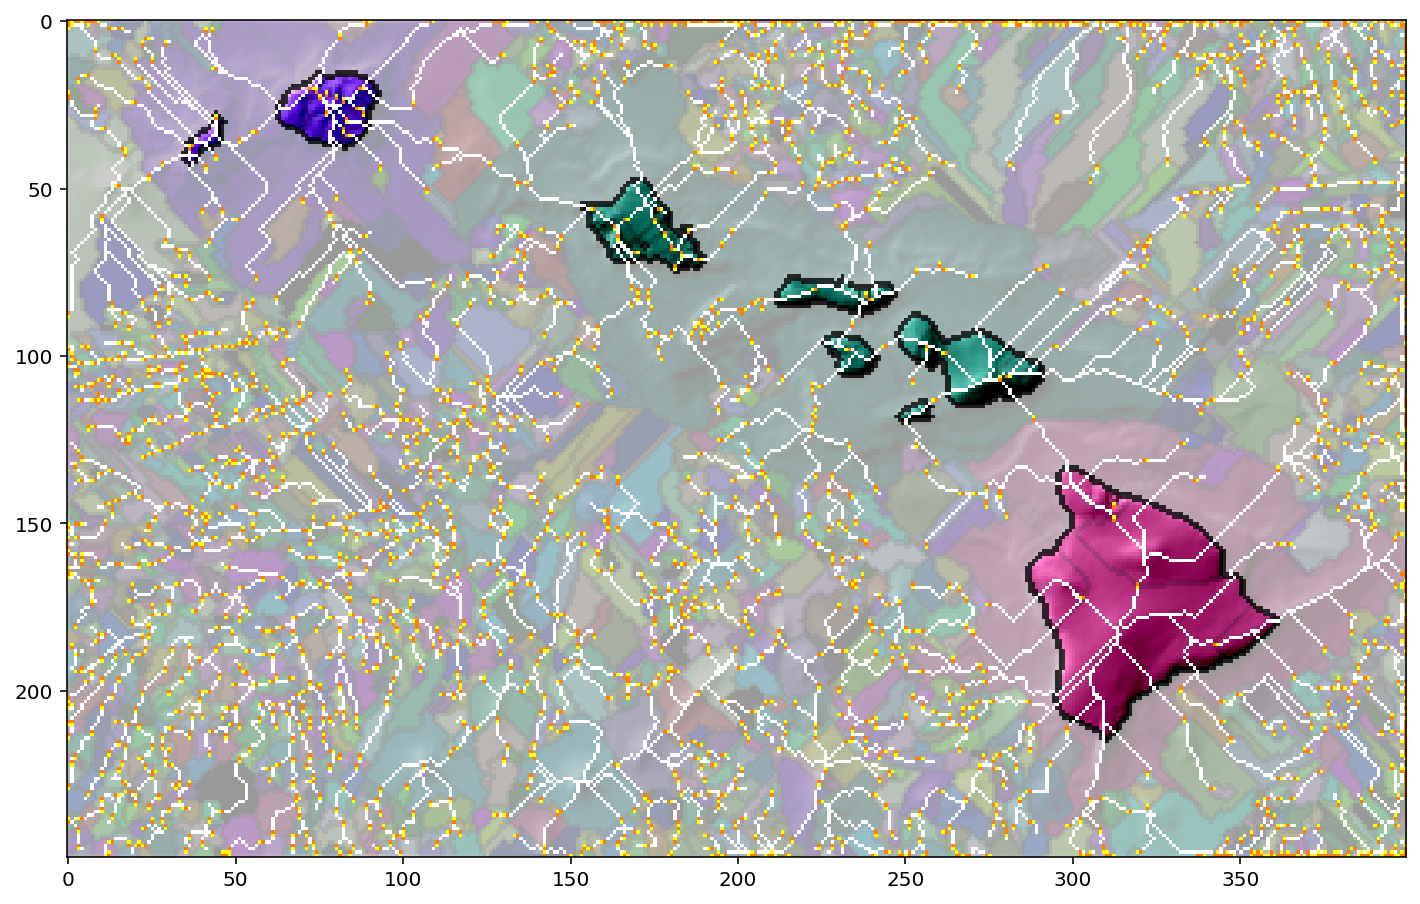

In [7]:
# Add rivers from all of the ridge nodes
# We can look at all of the merge points and draw ridge lines
# up to the peaks on either side -- this is the tallest path connecting 
# the two mountains

def getRidgeLines(params, maps, merges, draw=True):
    HAS_NO_HIGHER_NEIGHBOR = -1 # constant when we are at a local maximum
    nodes_highest_neighbor_index = maps['highest_neighbor_index'].getDataFlat()
    nodes_ridge = np.zeros(params['n_nodes'], dtype=bool)
    nodes_lo_bridge = np.zeros(params['n_nodes'], dtype=bool)
    nodes_hi_bridge = np.zeros(params['n_nodes'], dtype=bool)

    for i_merge in np.arange(len(merges)):
        merge = merges[i_merge]
        bridge_lo_index = merge['bridge_lo_index']
        bridge_hi_index = merge['bridge_hi_index']
        nodes_lo_bridge[bridge_lo_index] = True
        nodes_hi_bridge[bridge_hi_index] = True

        # Follow the nodes upward from the bridge on both sides, marking those as ridge nodes
        cur_node = bridge_lo_index
        while cur_node != HAS_NO_HIGHER_NEIGHBOR:
            nodes_ridge[cur_node] = True
            cur_node = nodes_highest_neighbor_index[cur_node]
        cur_node = bridge_hi_index
        while cur_node != HAS_NO_HIGHER_NEIGHBOR:
            nodes_ridge[cur_node] = True
            cur_node = nodes_highest_neighbor_index[cur_node]
            
    # Draw the map
    if draw:
        RasterImage(maps['elevation']) \
            .addLayer('base', 1) \
            .addLayer('mountain_border', 0.8, nodes_selected=maps['mountain_border'].getDataFlat()) \
            .addLayer('mntrange_border', 0.8, nodes_selected=map_mntrange_border.getDataFlat(), combine='multiply') \
            .addLayer('mntrange', map_mntrange.getDataFlat(), colormap='hashed', combine='multiply', opacity=0.5) \
            .addLayer('hillshade', maps['hillshade'].getDataFlat(), combine='add', opacity=1, dissolve=1) \
            .addLayer('sea', 1.2, nodes_selected=maps['sea'].getDataFlat(), combine='add', dissolve=.2) \
            .addLayer('coast', 0.2, nodes_selected=maps['coast'].getDataFlat(), combine='multiply') \
            .addLayer('ridge', 1, nodes_selected=nodes_ridge, combine='set') \
            .addLayer('lo_ridge', [1, 1, 0], nodes_selected=nodes_lo_bridge, combine='set') \
            .addLayer('hi_ridge', [1, .5, 0], nodes_selected=nodes_hi_bridge, combine='set') \
            .display().overrideLayerNames(['mountain_range_algo2_ridges1']).final()
    
    return nodes_ridge

nodes_ridge = getRidgeLines(params, maps, merges)
    

### Ridge Line visualization Analysis
The ridge lines as-is are interesting but we don't have a great way to compare the importance of them. For instance, all of the seafloor ridges show interesting patterns but are essentially noise -- they don't matter. Where multiple ridges come together or they connect large areas -- that's really important.

Perhaps we can change the significance of the rivers/ridges by the power, some ideas:
* Color by elevation
* Color by how much mass is passed through the river. What does mass mean?
  * The number of nodes that flow into this node?
  * The total value flowing

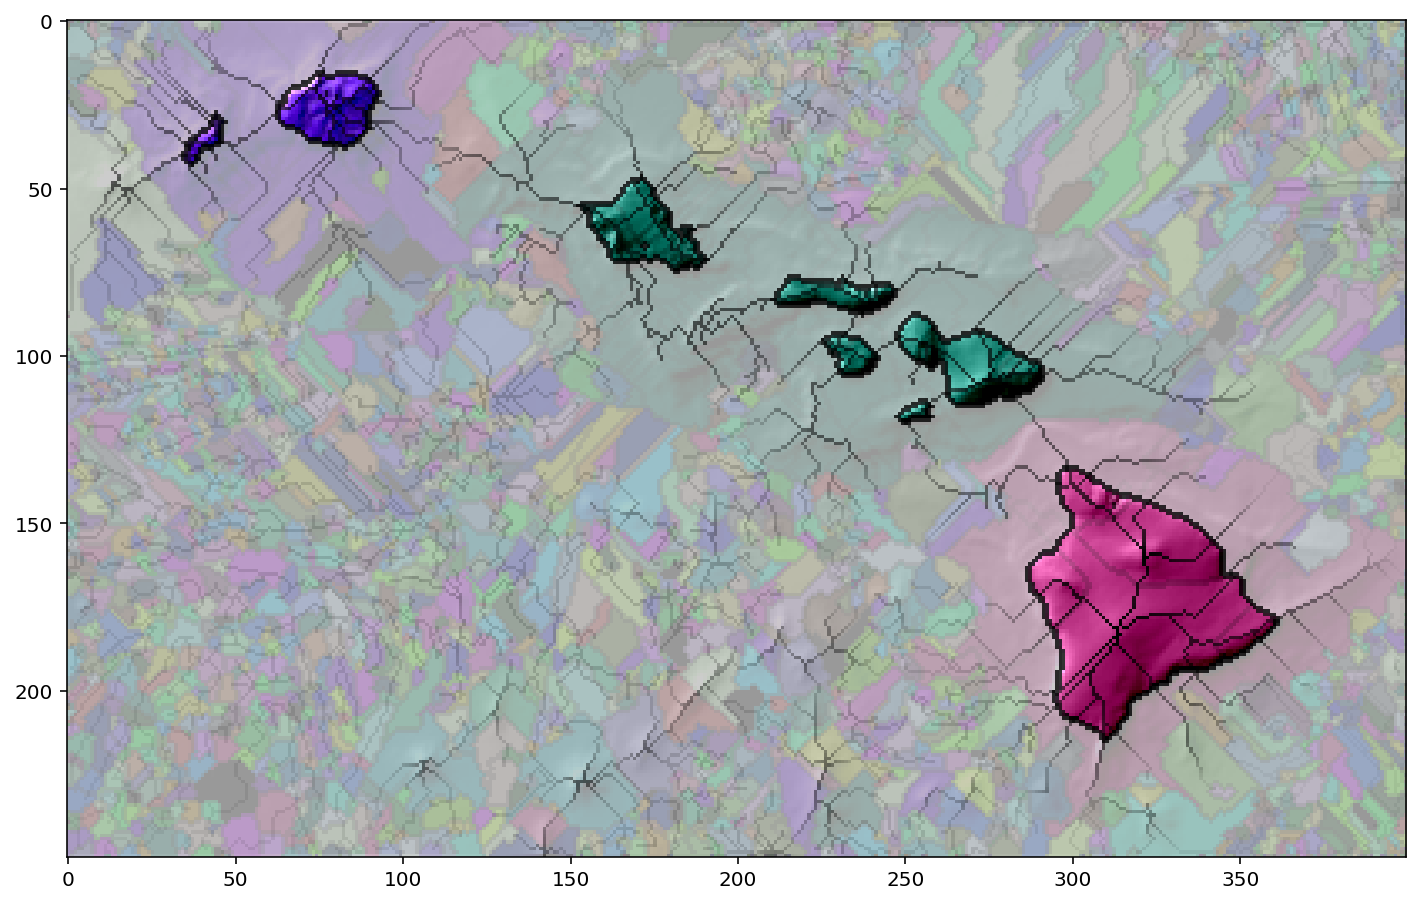

In [8]:
# Show rivers by their elevation

# Draw the map
RasterImage(maps['elevation']) \
    .addLayer('base', 1) \
    .addLayer('mountain_border', 0.8, nodes_selected=maps['mountain_border'].getDataFlat()) \
    .addLayer('mntrange_border', 0.8, nodes_selected=map_mntrange_border.getDataFlat(), combine='multiply') \
    .addLayer('mntrange', map_mntrange.getDataFlat(), colormap='hashed', combine='multiply', opacity=0.5) \
    .addLayer('hillshade', maps['hillshade'].getDataFlat(), combine='add', opacity=1, dissolve=1) \
    .addLayer('sea', 1.2, nodes_selected=maps['sea'].getDataFlat(), combine='add', dissolve=.2) \
    .addLayer('coast', 0.2, nodes_selected=maps['coast'].getDataFlat(), combine='multiply') \
    .addLayer('ridge', -maps['elevation'].getDataFlat(), nodes_selected=nodes_ridge, transforms='norm', combine='multiply') \
    .display().overrideLayerNames(['mountain_range_algo2_ridges2']).final()

### Computing the global ridge graph
In order to do this, we may need to compute the "taller node" values but in a way that connects all to the highest peak. Right now all taller nodes point to the local peak -- but what if we change the direction of flow along the ridges that connect them so that Peak A flows into Peak B insted of being a terminal itself.

This is easy for two adjacent peaks -- but we will have a longer path to combine as we merge more. We can compute this by looking at the merge sites and work updates -- look at the lowest elevation merge, change the river of the lower peak to point to the higher peak, then repeat for all merge sites, using the updated "taller" graph.

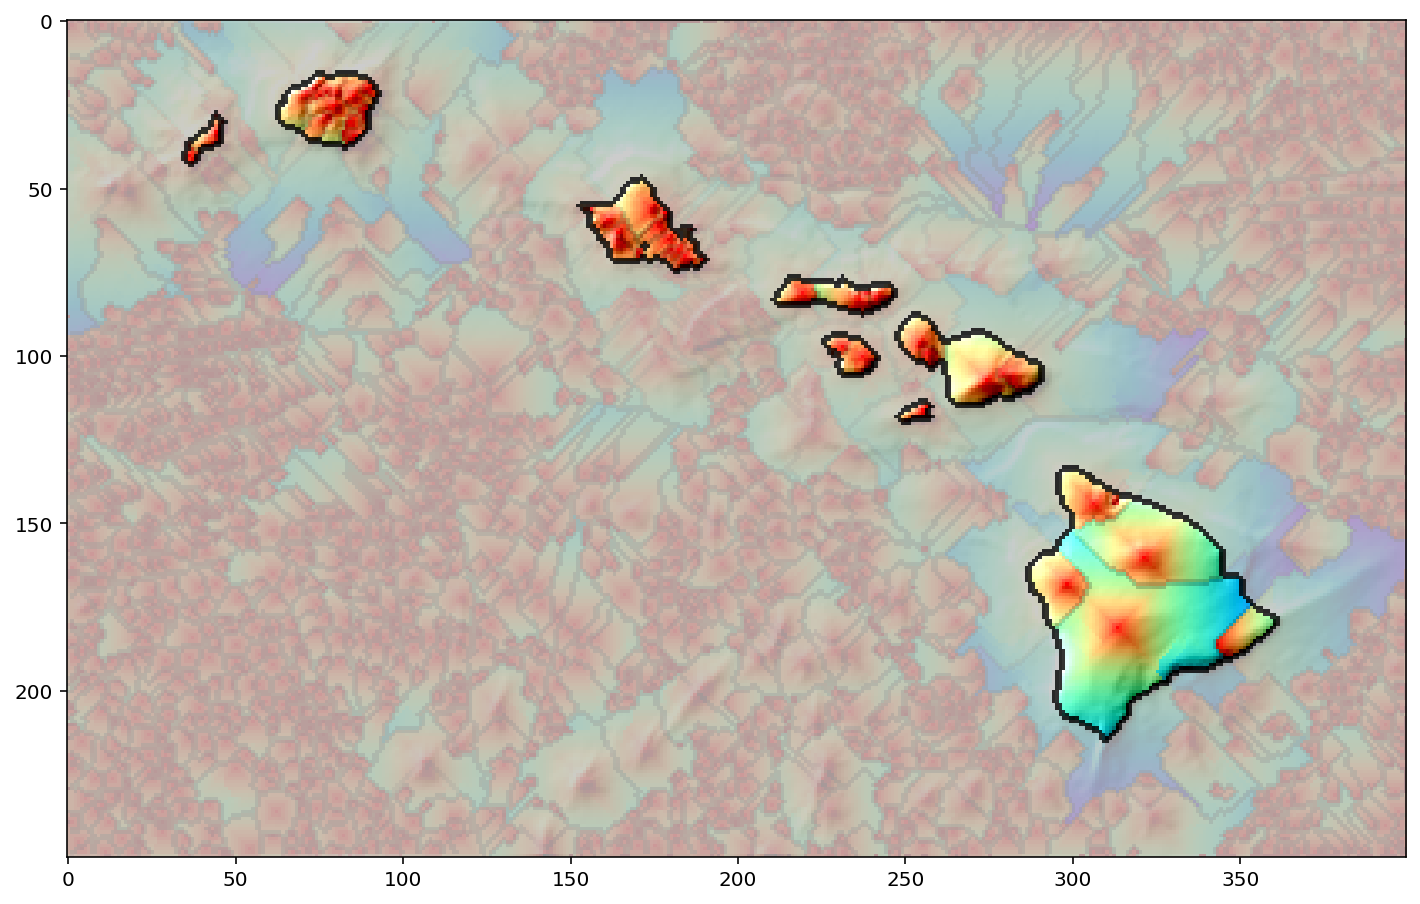

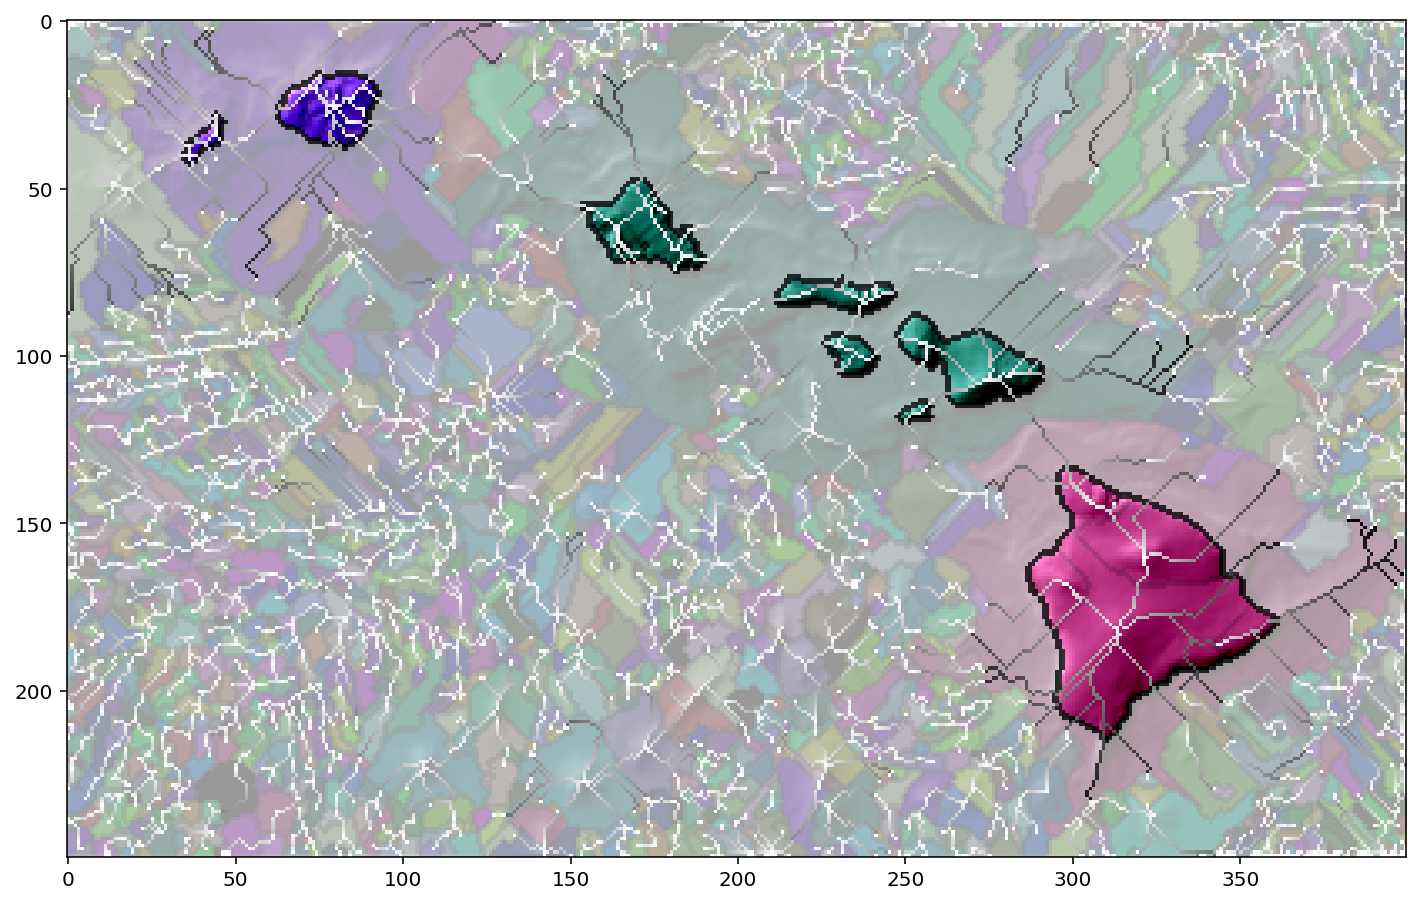

In [9]:
# Let's get a sense for the pattern of ridges coming together by working backwards from the tallest

def renderRidgeDistanceFromLocalPeak(maps, map_mntrange_border):
    nodes_value = maps['elevation'].getDataFlat()
    nodes_highest_neighbor_index = maps['highest_neighbor_index'].getDataFlat()
    nodes_distance_from_local_peak = np.zeros(params['n_nodes'], dtype=int) - 1

    # start from the globally tallest node and go down
    nodes_index_hi_to_lo = np.argsort(-nodes_value);
    for node_index in nodes_index_hi_to_lo:
        uphill_node_index = nodes_highest_neighbor_index[node_index]
        node_distance = 0 if uphill_node_index == -1 else nodes_distance_from_local_peak[uphill_node_index]
        nodes_distance_from_local_peak[node_index] = node_distance + 1

    # Draw the mountains by their distance from the peaks
    nodes_distance_normed = -np.sqrt(nodes_distance_from_local_peak)
    RasterImage(maps['elevation']) \
        .addLayer('base', 1) \
        .addLayer('mountain_border', 0.8, nodes_selected=maps['mountain_border'].getDataFlat()) \
        .addLayer('mntrange_border', 0.8, nodes_selected=map_mntrange_border.getDataFlat(), combine='multiply') \
        .addLayer('dist_from_peak', nodes_distance_normed, transforms=['norm'], colormap='rainbow', combine='multiply', opacity=0.5) \
        .addLayer('hillshade', maps['hillshade'].getDataFlat(), combine='add', opacity=1, dissolve=1) \
        .addLayer('sea', 1.2, nodes_selected=maps['sea'].getDataFlat(), combine='add', dissolve=.2) \
        .addLayer('coast', 0.2, nodes_selected=maps['coast'].getDataFlat(), combine='multiply') \
        .display().overrideLayerNames(['mountain_range_algo2_dist_from_peak']).save().final()

    # Draw the ridges only
    RasterImage(maps['elevation']) \
        .addLayer('base', 1) \
        .addLayer('mountain_border', 0.8, nodes_selected=maps['mountain_border'].getDataFlat()) \
        .addLayer('mntrange_border', 0.8, nodes_selected=map_mntrange_border.getDataFlat(), combine='multiply') \
        .addLayer('mntrange', map_mntrange.getDataFlat(), colormap='hashed', combine='multiply', opacity=0.5) \
        .addLayer('hillshade', maps['hillshade'].getDataFlat(), combine='add', opacity=1, dissolve=1) \
        .addLayer('sea', 1.2, nodes_selected=maps['sea'].getDataFlat(), combine='add', dissolve=.2) \
        .addLayer('coast', 0.2, nodes_selected=maps['coast'].getDataFlat(), combine='multiply') \
        .addLayer('ridge_dist_from_peak', nodes_distance_normed, transforms=['norm'], nodes_selected=nodes_ridge, combine='set') \
        .display().overrideLayerNames(['mountain_range_algo2_ridge_dist_from_peak']).save().final()
    
renderRidgeDistanceFromLocalPeak(maps, map_mntrange_border)

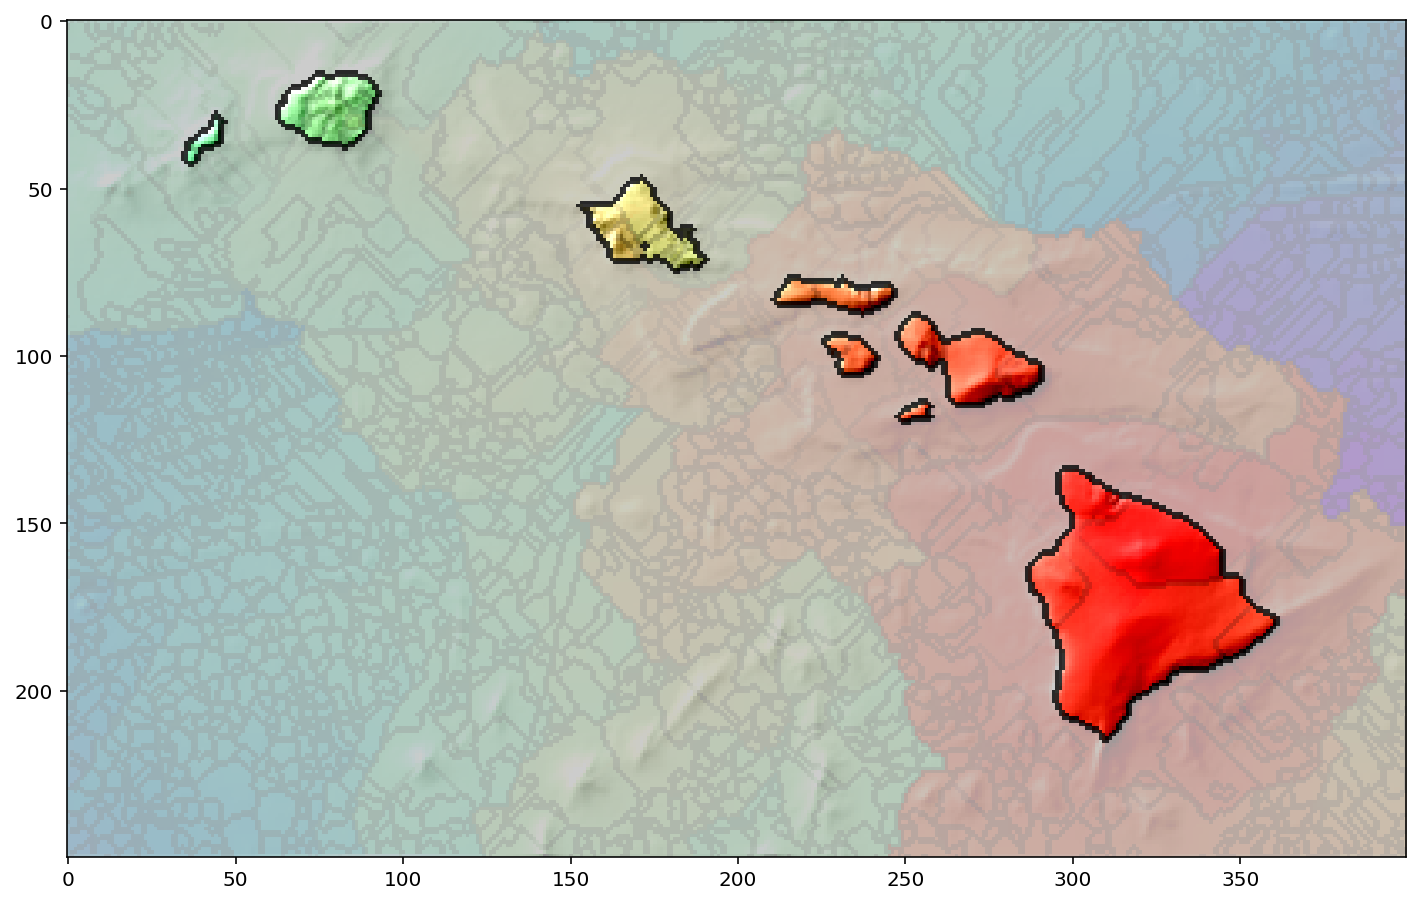

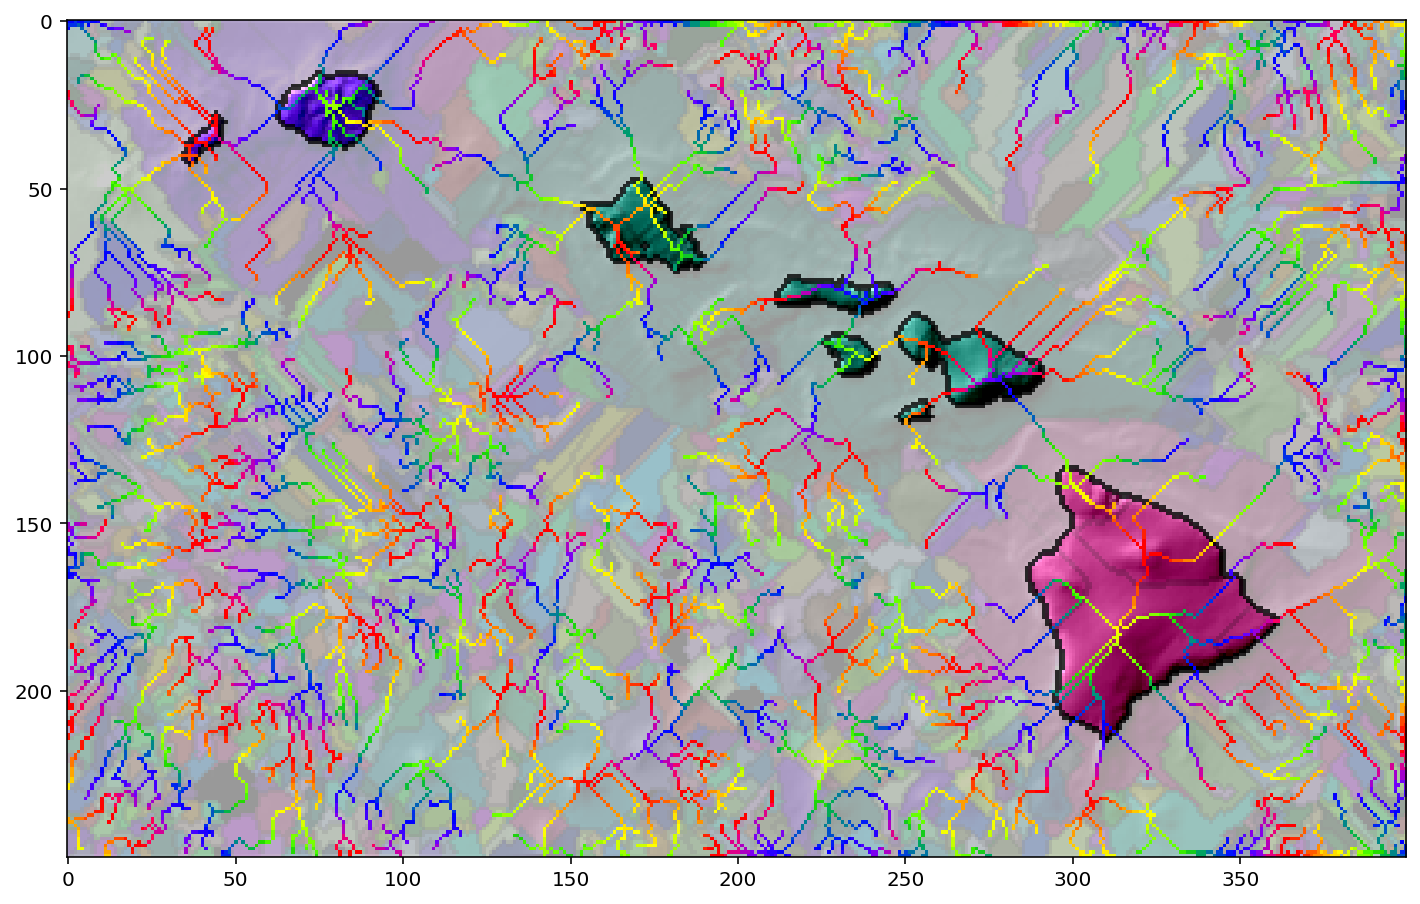

In [10]:
# Now lets compute the global ridgelines
# Go through all merge lines

def drawGlobalRidgeParentGradient(params, maps):

    nodes_global_ridge_parent = maps['highest_neighbor_index'].getDataFlat()

    for merge in reversed(merges):
        node_being_flipped = merge['bridge_lo_index']
        node_new_uphill = merge['bridge_hi_index']

        while node_being_flipped != -1:
            node_old_uphill = nodes_global_ridge_parent[node_being_flipped]
            nodes_global_ridge_parent[node_being_flipped] = node_new_uphill
            node_new_uphill = node_being_flipped
            node_being_flipped = node_old_uphill

    # Now we have a new river graph, let's redo the distance
    nodes_distance_from_global_peak = np.zeros(params['n_nodes'], dtype=int)

    # This time we cannot go by the elevations because some low-elevation nodes may be "higher" in this new river graph
    # so we have to iterate through the 
    exploring_nodes = np.where(nodes_global_ridge_parent == -1)[0]

    for i_node in np.arange(params['n_nodes']):
        node_index = exploring_nodes[i_node]

        uphill_node_index = nodes_global_ridge_parent[node_index]
        node_distance = 0 if uphill_node_index == -1 else nodes_distance_from_global_peak[uphill_node_index]
        nodes_distance_from_global_peak[node_index] = node_distance + 1

        # Add next nodes to the queue
        exploring_nodes = np.append(exploring_nodes, np.where(nodes_global_ridge_parent == node_index)[0])

    # Draw the mountains by their distance from the peaks
    nodes_global_distance_normed = -nodes_distance_from_global_peak
    RasterImage(maps['elevation']) \
        .addLayer('base', 1) \
        .addLayer('mountain_border', 0.8, nodes_selected=maps['mountain_border'].getDataFlat()) \
        .addLayer('mntrange_border', 0.8, nodes_selected=map_mntrange_border.getDataFlat(), combine='multiply') \
        .addLayer('dist_from_global_peak', nodes_global_distance_normed, transforms=['norm'], colormap='rainbow', combine='multiply', opacity=0.5) \
        .addLayer('hillshade', maps['hillshade'].getDataFlat(), combine='add', opacity=1, dissolve=1) \
        .addLayer('sea', 1.2, nodes_selected=maps['sea'].getDataFlat(), combine='add', dissolve=.2) \
        .addLayer('coast', 0.2, nodes_selected=maps['coast'].getDataFlat(), combine='multiply') \
        .display().overrideLayerNames(['mountain_range_algo2_dist_from_global_peak_along_ridges']).save().final()

    # Draw the ridges only
    RasterImage(maps['elevation']) \
        .addLayer('base', 1) \
        .addLayer('mountain_border', 0.8, nodes_selected=maps['mountain_border'].getDataFlat()) \
        .addLayer('mntrange_border', 0.8, nodes_selected=map_mntrange_border.getDataFlat(), combine='multiply') \
        .addLayer('mntrange', map_mntrange.getDataFlat(), colormap='hashed', combine='multiply', opacity=0.5) \
        .addLayer('hillshade', maps['hillshade'].getDataFlat(), combine='add', opacity=1, dissolve=1) \
        .addLayer('sea', 1.2, nodes_selected=maps['sea'].getDataFlat(), combine='add', dissolve=.2) \
        .addLayer('coast', 0.2, nodes_selected=maps['coast'].getDataFlat(), combine='multiply') \
        .addLayer('ridge_dist_from_global_peak', -nodes_global_distance_normed, colormap='prism', transforms=['norm'], nodes_selected=nodes_ridge, combine='set') \
        .display().overrideLayerNames(['mountain_range_algo2_ridge_dist_from_global_peak']).save().final()

drawGlobalRidgeParentGradient(params, maps)

## Distinguishing separate ranges: visualizing borders & splitting on merge points

I'm trying to capture 1) a better way to visualize the different regions but also 2) split the regions into sensible mountain ranges.

A good idea may be to focus on the 'merge' points -- where we connect two mountains to groups into ranges. Instead of allowing every merge -- we could block two mountains from merging, recognizing they are in different ranges. How do we decide this?
* Try to split things equally, 50% on one side, 50% on the other, and iterate
  * While this could work, it seems like it would be arbitrary
* Drop the "lowest" merge points
  * While this /could/ work, it would prevent us from combining the underwater mountain ranges that we visually can justify. 
  * This is what we already see by the visualizations above taking a snapshot @ 1/8th the way there.
* Only allow underwater merge points for underwater ranges and overland (aka subaerial) merge points for overland ranges -- this could make sense
* Distinguish "plains" or "plateaus" from the mountain ranges -- drop merge points in plains.
  * That's an interesting idea but will require us to define what a plain is, which sounds like a good followup but yet another way to define a region.
* Prevent merges when there's a big difference between the merge points & the peaks
  * eg. both peaks are really tall, but the merge point is far below it
  * Or the combined distance between the merge point & 2 peaks is differnt
  * I think this may work, but it looks like a threshold that would have to be calibrated -- also if we use this to split 2 regions, would that mean we split?
  * Another decision criteria here: do we mean the highest peak in the range or just the peak between the two merge points?

Another idea is to not focus on splitting merge points, but if we try every split, computing what the persistent borders are. For example, at every merge point compute the border between the ranges on either side -- and repeat this over and over and add up the borders that persist the most. On the Hawaii example I think this would distinguish the ocean plain from the main island groups.

There also is rationale to not over-focus on 1 merging point (since it could be many) and try to use graph algorithms with approximate cost functions, guessing ranges and converge on solutions. That sounds computationally difficult on this voxel approach but that may mirror human judgment and pattern matching better.

Anyway, for now, let's just try some of those un-merging ideas above

In [11]:
### Re-grouping #1
# Only allow underwater merge points for underwater ranges 
# and overland (aka subaerial) merge points for overland ranges

# Algorithm
# We want to iterate through X many merge points
#     X is all or maybe a fixed number, fraction of all merge points, or uses a threshold like the side on either side)
# For each of these merge points compute the mountains on either side using a BFS to find the connected components
#     Then split into 2 groups

# Let's re-compute the land-sea interface for merges now that we new global mountain ranges
def printMergeInterfaceStatistics(merges, nodes_mountain): 
    print('Think of the intersections like V shapes. tall peak -> bridge -> small peak')
    print('Do the ridges in the connections cross the water line / interface? Considering what is above water (L) or below (S)?')
    landsea_local_interfaces = np.array([x['landsea_local_interface'] for x in merges])
    landsea_range_interfaces = np.array([x['landsea_range_interface'] for x in merges])
    print('{:18s}: {:6s} {:6s}'.format('Interface Pattern','Local','Range'))
    for interface_pattern in sorted(np.unique(landsea_local_interfaces)):
        print('{:18s}: {:6d} {:6d}'.format(
            interface_pattern,
            np.sum(landsea_local_interfaces == interface_pattern),
            np.sum(landsea_range_interfaces == interface_pattern),
        ))
    
printMergeInterfaceStatistics(merges, maps['mountain'].getDataFlat())

Think of the intersections like V shapes. tall peak -> bridge -> small peak
Do the ridges in the connections cross the water line / interface? Considering what is above water (L) or below (S)?
Interface Pattern : Local  Range 
LLL               :     42     42
LSL               :      5      8
LSS               :     85   1319
SSL               :      1      0
SSS               :   2203    967


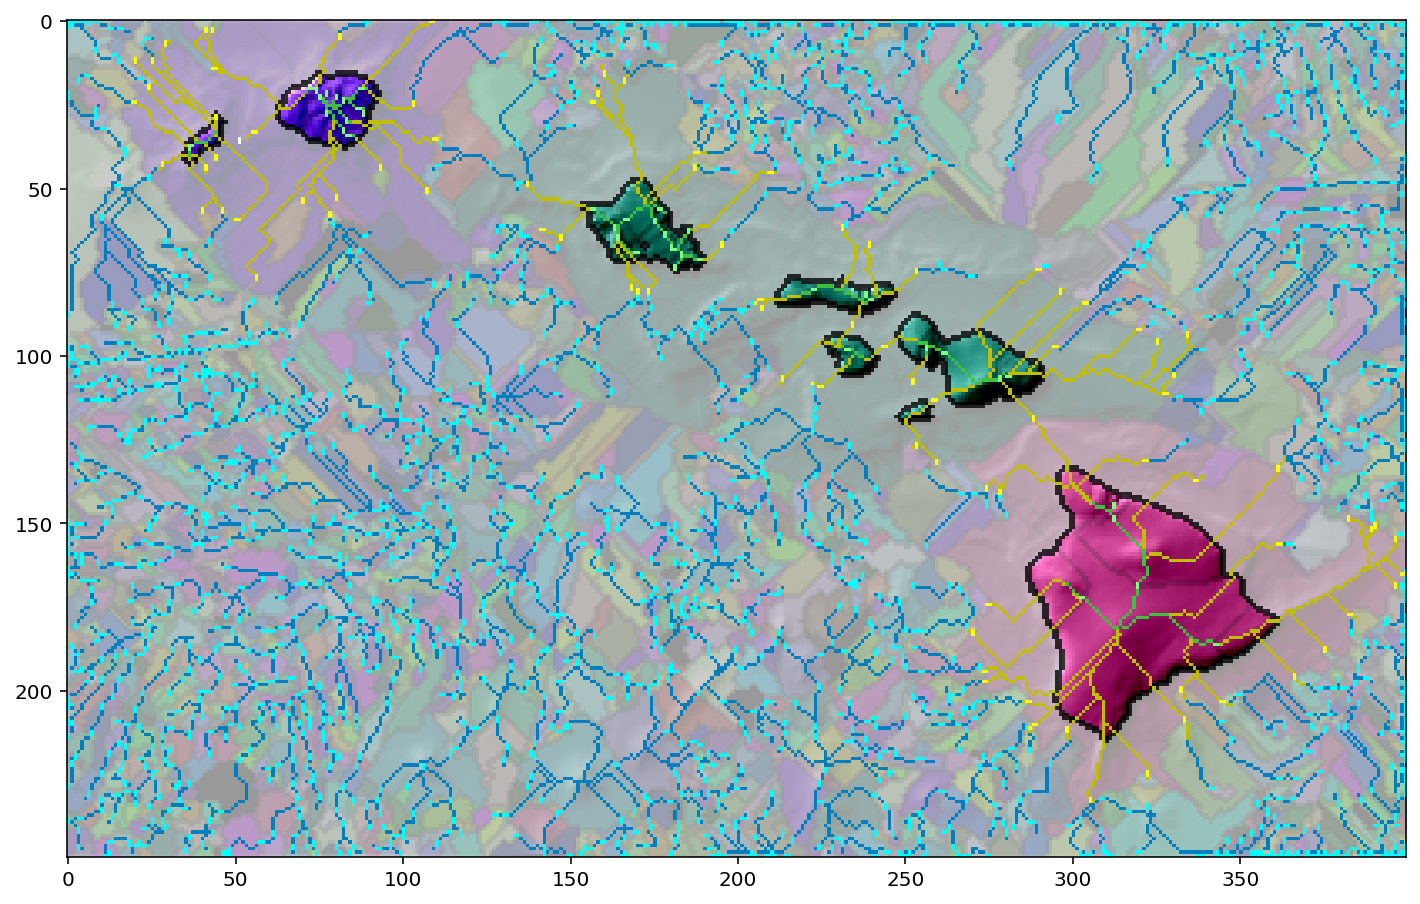

In [12]:
### Re-grouping #1
# Only allow underwater merge points for underwater ranges 
# and overland (aka subaerial) merge points for overland ranges

# Algorithm
# We want to iterate through X many merge points
#     X is all or maybe a fixed number, fraction of all merge points, or uses a threshold like the side on either side)
# For each of these merge points compute the mountains on either side using a BFS to find the connected components
#     Then split into 2 groups

# Visualize the different merge domain types
# We can use the same algorithm used to draw ridge lines

def drawRidgeInterfaceType(params, maps, merges):
    nodes_highest_neighbor_index = maps['highest_neighbor_index'].getDataFlat()
    nodes_ridge_interface = np.full(params['n_nodes'], 'UNK')
    nodes_bridge = np.zeros(params['n_nodes'], dtype=bool)
    nodes_mountain_merge_interface = np.full(params['n_nodes'], 'UNK')
    nodes_value = maps['elevation'].getDataFlat()

    for merge in merges:
        node_lo = merge['bridge_lo_index']
        node_hi = merge['bridge_hi_index']
        merge_interface = merge['landsea_local_interface']

        nodes_bridge[node_lo] = True
        nodes_bridge[node_hi] = True

        # Determine the type of ridges from both merge points to their local peak
        cur_node = node_lo
        while cur_node != -1:
            nodes_ridge_interface[cur_node] = min(merge_interface, nodes_ridge_interface[cur_node])
            nodes_mountain_merge_interface[cur_node] = min(merge_interface, nodes_mountain_merge_interface[cur_node])
            cur_node = nodes_highest_neighbor_index[cur_node]
        cur_node = node_hi
        while cur_node != -1:
            nodes_ridge_interface[cur_node] = min(merge_interface, nodes_ridge_interface[cur_node])
            cur_node = nodes_highest_neighbor_index[cur_node]

    # Draw the map
    RasterImage(maps['elevation']) \
        .addLayer('base', 1) \
        .addLayer('mountain_border', 0.8, nodes_selected=maps['mountain_border'].getDataFlat()) \
        .addLayer('mntrange_border', 0.8, nodes_selected=map_mntrange_border.getDataFlat(), combine='multiply') \
        .addLayer('mntrange', map_mntrange.getDataFlat(), colormap='hashed', combine='multiply', opacity=0.5) \
        .addLayer('hillshade', maps['hillshade'].getDataFlat(), combine='add', opacity=1, dissolve=1) \
        .addLayer('sea', 1.2, nodes_selected=maps['sea'].getDataFlat(), combine='add', dissolve=.2) \
        .addLayer('coast', 0.2, nodes_selected=maps['coast'].getDataFlat(), combine='multiply') \
        .addLayer('ridge_merged_LLL', [.25, .75, .25], nodes_selected=(nodes_ridge_interface == 'LLL'), combine='set') \
        .addLayer('ridge_merged_SSS', [  0,  .5, .75], nodes_selected=(nodes_ridge_interface == 'SSS'), combine='set') \
        .addLayer('ridge_merged_LSS', [.75, .75,   0], nodes_selected=(nodes_ridge_interface == 'LSS'), combine='set') \
        .addLayer('ridge_merged_LSL', [.75, .75,   0], nodes_selected=(nodes_ridge_interface == 'LSL'), combine='set') \
        .addLayer('bridge', 2, nodes_selected=nodes_bridge, combine='multiply') \
        .display().overrideLayerNames(['heterogenous_peak_merges']).final()
    
    return [nodes_ridge_interface, nodes_bridge]
    
[nodes_ridge_interface, nodes_bridge] = drawRidgeInterfaceType(params, maps, merges)

### Analysis 
Lets try grouping the ranges without these merge but we can already notice a few weaknesses
* There are lots of tendrils from the islands into small underwater peaks, seemingly from subtle underwater mounds
* There's a ridge above Maui that visually connects to Molokai but here we see it merged into Maui -- presumably because there was a larger underwater gap between it and its visually apparent neighbor -- this definitely adds to the idea we need to take larger shapes into consideration
* Hawaii & Maui (& co) are joined because here we only compared the peak's status (2 overland peaks) not if the merge point was underwater. If we compare peak 1, the mergepoint, and peak 2 as land (L) or sea (S), we may want a different schema
  * LLL, SSS -> accepted, makes sense
  * LSL -> accepted as of this, probably shouldn't
  * SLS is not possible since we go from high to low)
  * What about LLS or LSS? I'm not sure. I suspect that will cause Oahu to eat up the coastal plain again, which does not appear right. But it will separate the islands.

Regardless, let's still draw it out. After, let's continue to iterate on different criteria to separate the merge points.

In [13]:
### Adjacency list
# It will save us a lot of time if we compute the adjacency list
# note: Since we constructed this with a union/find algorithm, we know there are no cycles in this graph

def getMountainAdjacencyList(merges, verbose=False):
    mountains_adjacency_list = {}

    for merge in merges:
        node_lo = merge['bridge_lo_index']
        node_hi = merge['bridge_hi_index']
        m1 = merge['mountain_lo']
        m2 = merge['mountain_hi']

        if m1 in mountains_adjacency_list:
            mountains_adjacency_list[m1] = np.append(mountains_adjacency_list[m1], m2)
        else:
            mountains_adjacency_list[m1] = np.array([m2])
        if m2 in mountains_adjacency_list:
            mountains_adjacency_list[m2] = np.append(mountains_adjacency_list[m2], m1)
        else:
            mountains_adjacency_list[m2] = np.array([m1])

    if verbose:
        # Print out descriptive statistics
        mountains_adjacency_list_cardinality = np.array([len(mountains_adjacency_list[x]) for x in mountains_adjacency_list])
        n_mountains_1_connection = np.sum(mountains_adjacency_list_cardinality == 1)
        n_mountains_morethan5_connections = np.sum(mountains_adjacency_list_cardinality > 5)
        n_mountains_2to5_connections = len(mountains_adjacency_list) - n_mountains_1_connection - n_mountains_morethan5_connections
        print((
                'Mountains with   1 connection : {:6d}\n' +
                'Mountains with 2-5 connections: {:6d}\n' +
                'Mountains with  >5 connections: {:6d}\n'
              )
              .format(
                  n_mountains_1_connection,
                  n_mountains_2to5_connections,
                  n_mountains_morethan5_connections
              ))
        
    return mountains_adjacency_list

mountains_adjacency_list = getMountainAdjacencyList(merges, verbose=True)

Mountains with   1 connection :    802
Mountains with 2-5 connections:   1513
Mountains with  >5 connections:     22



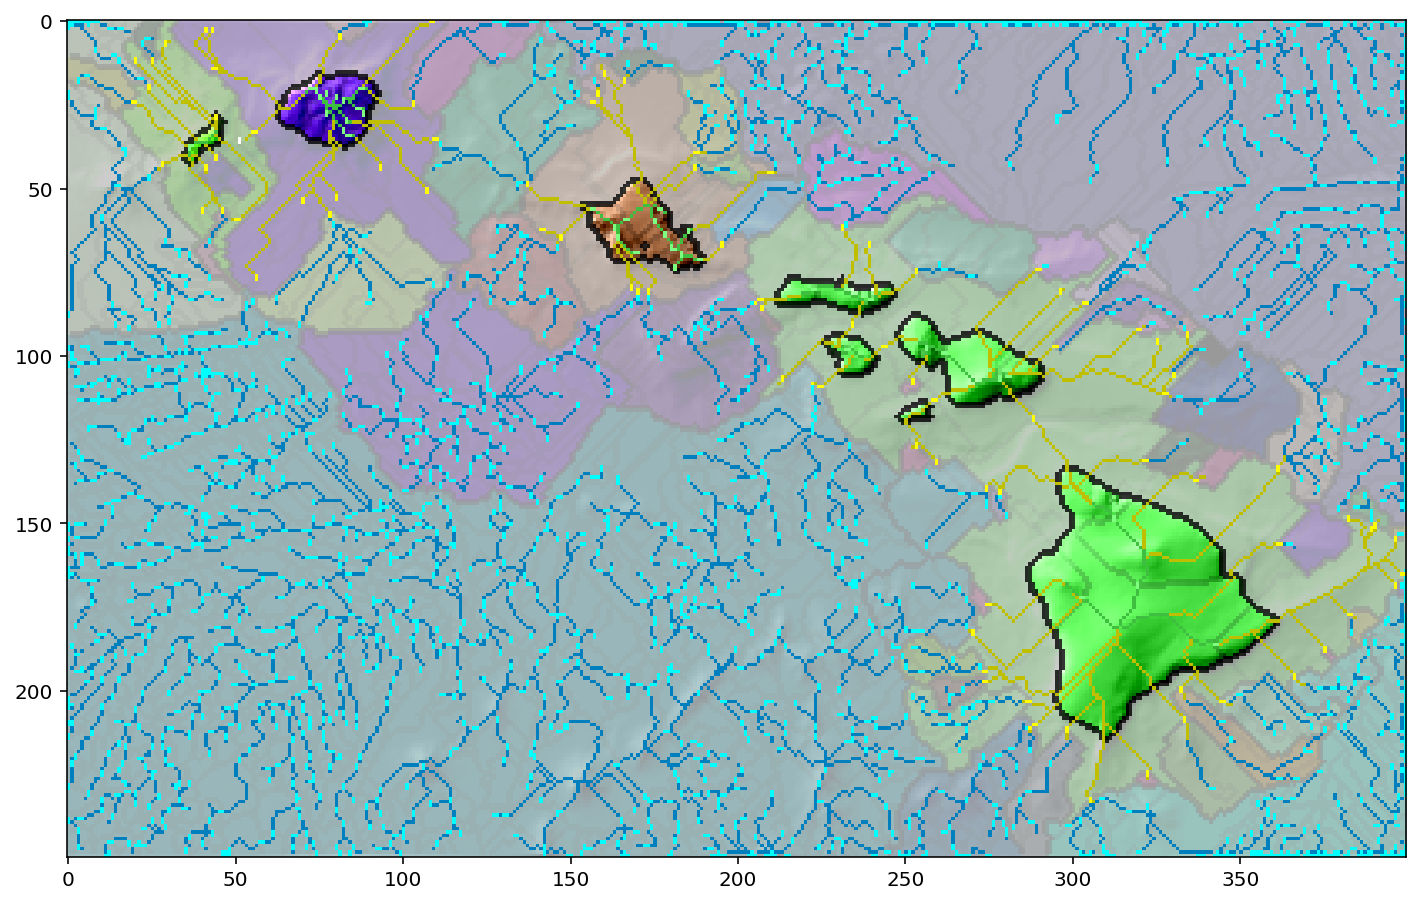

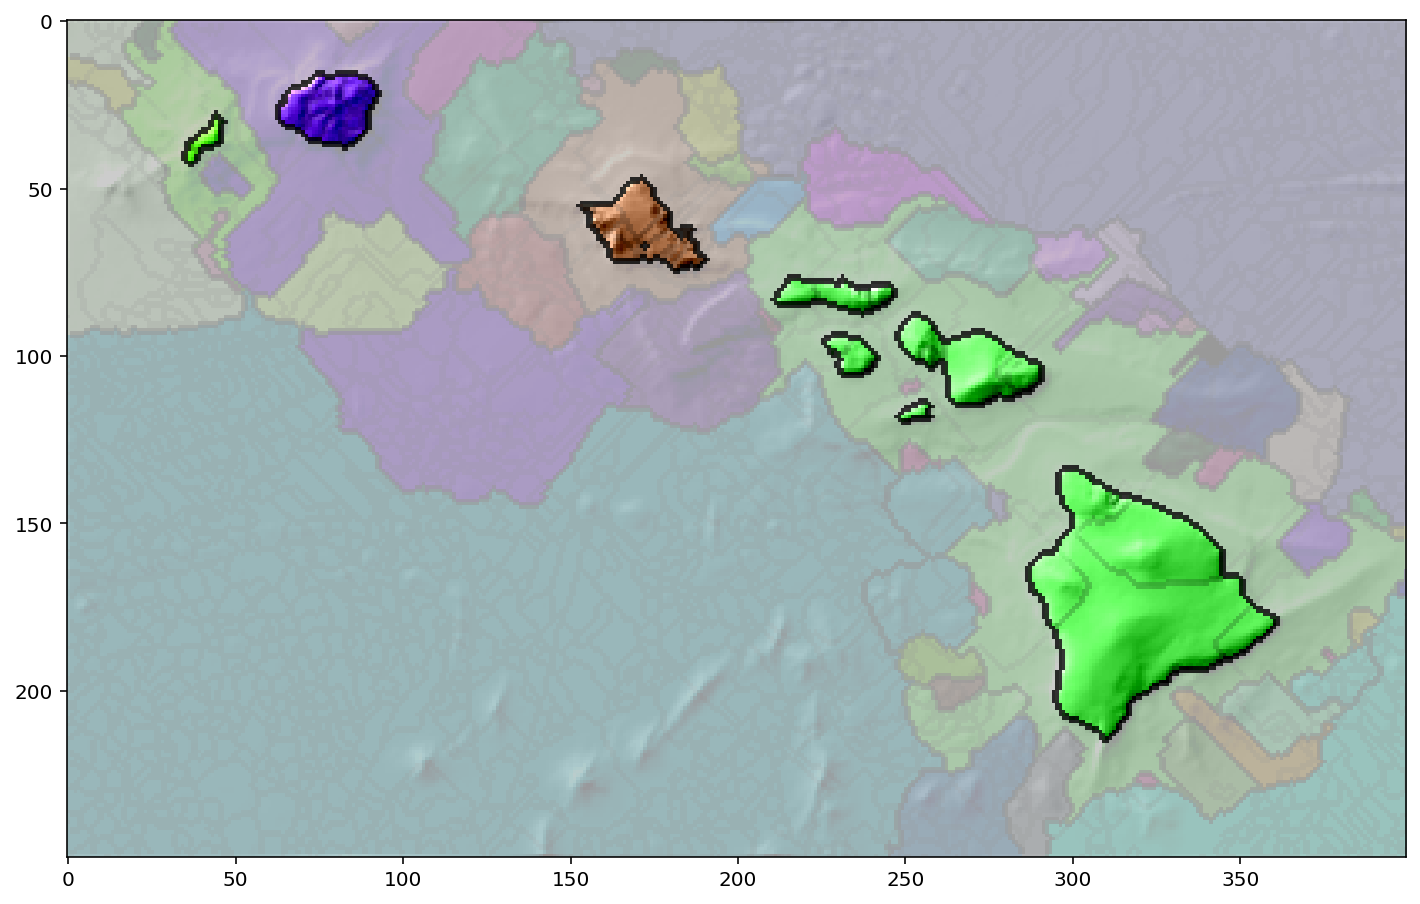

In [14]:
### Breaking apart the mergepoints
# In order to break them apart and draw the different mountain groupings,
#   we will need to perform a BFS at each mergepoint and separate the mountain groupings

def drawMountainGroupsBreakingUpBridgesByInterface(maps, merges, nodes_ridge_interface, nodes_bridge, interfaces_to_split=['LSS']):
    # The data we have
    nodes_mountain = maps['mountain'].getDataFlat() # Use this to color the whole mountains by the new range
    nodes_value = maps['elevation'].getDataFlat() # Use this to see if a peak is above or below water
    mountains_adjacency_list = getMountainAdjacencyList(merges) # start from scratch because we will actively edit it

    # The data we are computing
    node_global_peak_index = np.argsort(nodes_value)[0] # This is the parent mountain to all others
    nodes_mountain_group = np.full(params['n_nodes'], node_global_peak_index) # Start with everything being unified under this peak
    n_mountains = len(mountains_adjacency_list)

    # Function to re-assign mountain ranges to a new mountain group
    def reassignMountainGroupsOfRecursiveNeighbors(nodes_mountain_group, dividing_mountain, mountains_adjacency_list, nodes_value):
        exploring_mountains = [dividing_mountain];
        highest_group_mountain = dividing_mountain;

        # Assign all recursive neighbors of dividing_mountain to its group
        while len(exploring_mountains) > 0:
            new_mountain = exploring_mountains.pop()
            if(nodes_value[new_mountain] > nodes_value[highest_group_mountain]):
                highest_group_mountain = new_mountain
            for neighbor_mountain in mountains_adjacency_list[new_mountain]:
                if nodes_mountain_group[neighbor_mountain] != dividing_mountain:
                    nodes_mountain_group[neighbor_mountain] = dividing_mountain
                    exploring_mountains.append(neighbor_mountain)

        # Reassign that whole group to the tallest peak in that group
        nodes_mountain_group[nodes_mountain_group == dividing_mountain] = highest_group_mountain

        return nodes_mountain_group


    # Iterate over the merge
    for merge in merges:
        if merge['landsea_local_interface'] not in interfaces_to_split:
            continue # We do not need to split this up

        # Break the adjacency
        m1 = merge['mountain_lo']
        m2 = merge['mountain_hi']
        mountains_adjacency_list[m1] = np.setdiff1d(mountains_adjacency_list[m1], [m2])
        mountains_adjacency_list[m2] = np.setdiff1d(mountains_adjacency_list[m2], [m1])

        # Compute the new groups (using stand-in values for the highest peak)
        # Note: We are doing double work since we don't know which side the overall peak is on
        nodes_mountain_group = reassignMountainGroupsOfRecursiveNeighbors(nodes_mountain_group, m1, mountains_adjacency_list, nodes_value)
        nodes_mountain_group = reassignMountainGroupsOfRecursiveNeighbors(nodes_mountain_group, m2, mountains_adjacency_list, nodes_value)

    # Finally expand the mountain group color to all nodes
    for mountain_index in np.arange(len(nodes_mountain)):
        nodes_mountain_group[nodes_mountain == mountain_index] = nodes_mountain_group[mountain_index]

    map_mntgroup = maps['mountain'].newChildInstance({'values': 'mountain_group'}, nodes_mountain_group)
    map_mntgroup_border = getBorder(map_mntgroup, 1)

    RasterImage(maps['elevation']) \
        .addLayer('base', 1) \
        .addLayer('mountain_border', 0.8, nodes_selected=maps['mountain_border'].getDataFlat()) \
        .addLayer('mntgroup_border', 0.5, nodes_selected=map_mntgroup_border.getDataFlat(), combine='multiply') \
        .addLayer('mmtgroup', nodes_mountain_group, colormap='hashed', combine='multiply', opacity=0.5) \
        .addLayer('hillshade', maps['hillshade'].getDataFlat(), combine='add', opacity=1, dissolve=1) \
        .addLayer('sea', 1.2, nodes_selected=maps['sea'].getDataFlat(), combine='add', dissolve=.2) \
        .addLayer('coast', 0.2, nodes_selected=maps['coast'].getDataFlat(), combine='multiply') \
        .addLayer('ridge_merged_LLL', [.25, .75, .25], nodes_selected=(nodes_ridge_interface == 'LLL'), combine='set') \
        .addLayer('ridge_merged_SSS', [  0,  .5, .75], nodes_selected=(nodes_ridge_interface == 'SSS'), combine='set') \
        .addLayer('ridge_merged_LSS', [.75, .75,   0], nodes_selected=(nodes_ridge_interface == 'LSS'), combine='set') \
        .addLayer('ridge_merged_LSL', [.75, .75,   0], nodes_selected=(nodes_ridge_interface == 'LSL'), combine='set') \
        .addLayer('bridges', 2, nodes_selected=nodes_bridge, combine='multiply') \
        .display().overrideLayerNames(['mountain_groups_separating_land_sea_peak_merges_ridges']).save().final()

    RasterImage(maps['elevation']) \
        .addLayer('base', 1) \
        .addLayer('mountain_border', 0.8, nodes_selected=maps['mountain_border'].getDataFlat()) \
        .addLayer('mntgroup_border', 0.5, nodes_selected=map_mntgroup_border.getDataFlat(), combine='multiply') \
        .addLayer('mmtgroup', nodes_mountain_group, colormap='hashed', combine='multiply', opacity=0.5) \
        .addLayer('hillshade', maps['hillshade'].getDataFlat(), combine='add', opacity=1, dissolve=1) \
        .addLayer('sea', 1.2, nodes_selected=maps['sea'].getDataFlat(), combine='add', dissolve=.2) \
        .addLayer('coast', 0.2, nodes_selected=maps['coast'].getDataFlat(), combine='multiply') \
        .display().overrideLayerNames(['mountain_groups_separating_land_sea_peak_merges']).save().final()
    
    return nodes_mountain_group

_ = drawMountainGroupsBreakingUpBridgesByInterface(maps, merges, nodes_ridge_interface, nodes_bridge, interfaces_to_split=['LSS'])
    

### Conclusion of Mountain Groupings by separating Land-Sea merges

While this partially worked (Ni'ihau, Lauai, and Oahu have their own spaces) most of the islands ended up merging. I think I will redo this analysis separating the mergers that happen over LSL and investigate what to do with LSS merges.